In [116]:
# 📌 Installation des librairies manquantes
!pip install tensorflow matplotlib pandas numpy pillow

# 📌 Importation des librairies
import os
import zipfile
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

In [117]:
import os
import tensorflow as tf
import zipfile

# 📌 URL publique du dataset sur S3
dataset_url = "https://skin-dataset-project-final.s3.amazonaws.com/dataset/oily-dry-and-normal-skin-types-dataset.zip"

# 📥 Téléchargement du fichier ZIP
dataset_path = tf.keras.utils.get_file(
    fname="oily-dry-and-normal-skin-types-dataset.zip",
    origin=dataset_url,
    extract=False  # Désactivation de l'extraction automatique
)

# 📌 Définition du chemin d'extraction
extract_path = os.path.join(os.path.dirname(dataset_path), "Oily-Dry-Skin-Types")

# 📂 Création du dossier d'extraction s'il n'existe pas
os.makedirs(extract_path, exist_ok=True)

# 🔓 Extraction manuelle du fichier ZIP
with zipfile.ZipFile(dataset_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# 📁 Vérification du contenu après extraction
if os.path.exists(extract_path):
    print(f"✅ Dataset extrait avec succès dans : {extract_path}")
    print(f"📁 Contenu : {os.listdir(extract_path)}")
else:
    print(f"⚠️ Problème : le dossier d'extraction n'existe pas : {extract_path}")

✅ Dataset extrait avec succès dans : /root/.keras/datasets/Oily-Dry-Skin-Types
📁 Contenu : ['Oily-Dry-Skin-Types']


In [118]:
# 📁 On réutilise `extract_path` défini ci dessus
dataset_root = os.path.join(extract_path, "Oily-Dry-Skin-Types")

# 📌 Vérification que le dossier existe bien
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"⚠️ Le dossier {dataset_root} n'existe pas. Vérifiez le téléchargement.")

print(f"✅ Dataset prêt à l'utilisation : {dataset_root}")

✅ Dataset prêt à l'utilisation : /root/.keras/datasets/Oily-Dry-Skin-Types/Oily-Dry-Skin-Types


In [119]:
# 📌 Définition des catégories et des datasets
categories = ["dry", "normal", "oily"]
folders = ["train", "valid", "test"]
datasets = {folder: os.path.join(dataset_root, folder) for folder in folders}

# 📌 Initialisation du dictionnaire des comptes
image_counts = {dataset: {cat: 0 for cat in categories} for dataset in datasets}

# 📌 Parcours des dossiers et comptage des fichiers images
for dataset_name, dataset_path in datasets.items():  # 📂 Associe train, valid, test à leurs chemins
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):  # Vérifier que le dossier existe
            image_counts[dataset_name][category] = len(os.listdir(category_path))  # Compter les fichiers

# ✅ Affichage des résultats
print("📊 Nombre d'images par catégorie et dataset :")
for dataset, counts in image_counts.items():
    print(f"\n📁 {dataset}:")
    for category, count in counts.items():
        print(f"  - {category}: {count} images")

📊 Nombre d'images par catégorie et dataset :

📁 train:
  - dry: 652 images
  - normal: 1104 images
  - oily: 1000 images

📁 valid:
  - dry: 71 images
  - normal: 111 images
  - oily: 80 images

📁 test:
  - dry: 35 images
  - normal: 59 images
  - oily: 40 images


In [120]:
# 📌 Conversion en DataFrame avec un index propre
df_counts = pd.DataFrame.from_dict(image_counts, orient="index")
df_counts.index = folders  # On remplace les chemins par 'train', 'valid', 'test'
df_counts.index.name = "Dataset"  # Renommer l'index pour plus de clarté

# 📌 Affichage du tableau propre
print("📊 Distribution des images par dataset et type de peau :")
display(df_counts)

📊 Distribution des images par dataset et type de peau :


,dry,normal,oily
Dataset,,,
train,652,1104,1000
valid,71,111,80
test,35,59,40


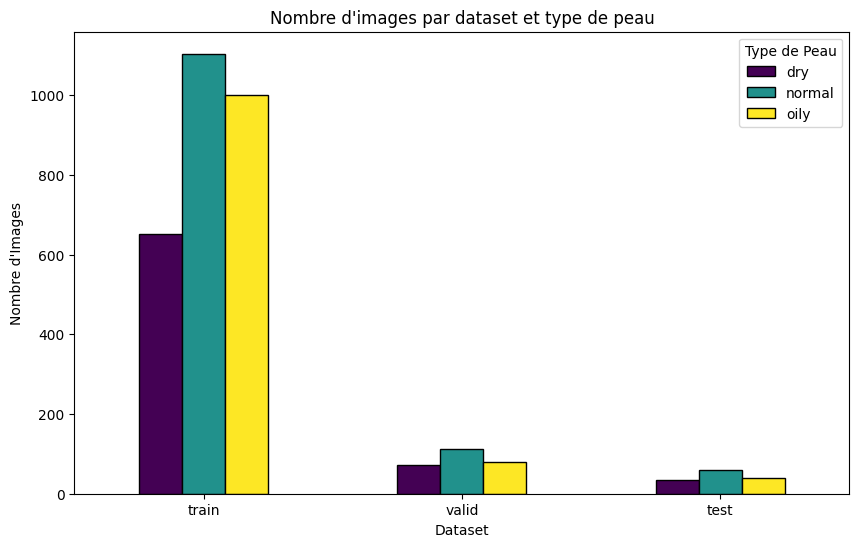

In [121]:
# 📌 Visualisation de la distribution des images
df_counts.plot(kind="bar", figsize=(10, 6), colormap="viridis", edgecolor="black")
plt.xlabel("Dataset")
plt.ylabel("Nombre d'Images")
plt.title("Nombre d'images par dataset et type de peau")
plt.xticks(rotation=0)
plt.legend(title="Type de Peau")
plt.show()

In [122]:
# 📌 Fonction pour afficher des images
def show_images(image_list, title, dataset_root, num_cols=5):
    """Affiche une sélection d'images dans un subplot."""
    num_images = len(image_list)
    num_rows = (num_images // num_cols) + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
    axes = axes.flatten()

    for i, img_name in enumerate(image_list):
        img_path = os.path.join(dataset_root, img_name)
        if not os.path.exists(img_path):
            print(f"⚠️ Fichier introuvable : {img_path}")
            continue

        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(img_name[:15])

    # Supprimer les cases vides
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.show()

In [123]:
# 📌 Définition du répertoire contenant les images
train_dir = os.path.join(dataset_root, "train")  # 📂 Dossier contenant les images d'entraînement

# 📌 Sélection de 5 images par catégorie
dry_images = [f"train/dry/{img}" for img in os.listdir(os.path.join(train_dir, "dry"))[:5]]
normal_images = [f"train/normal/{img}" for img in os.listdir(os.path.join(train_dir, "normal"))[:5]]
oily_images = [f"train/oily/{img}" for img in os.listdir(os.path.join(train_dir, "oily"))[:5]]

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


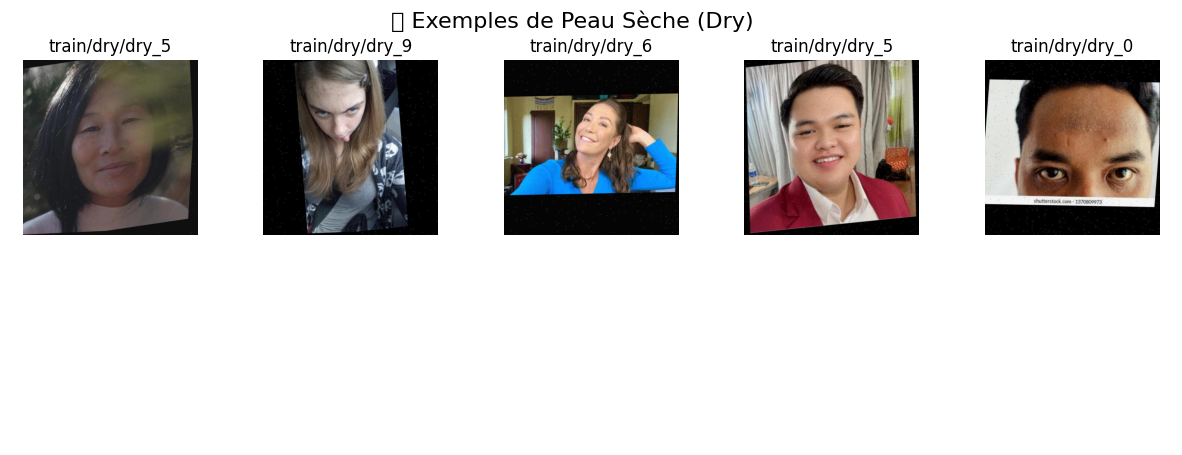

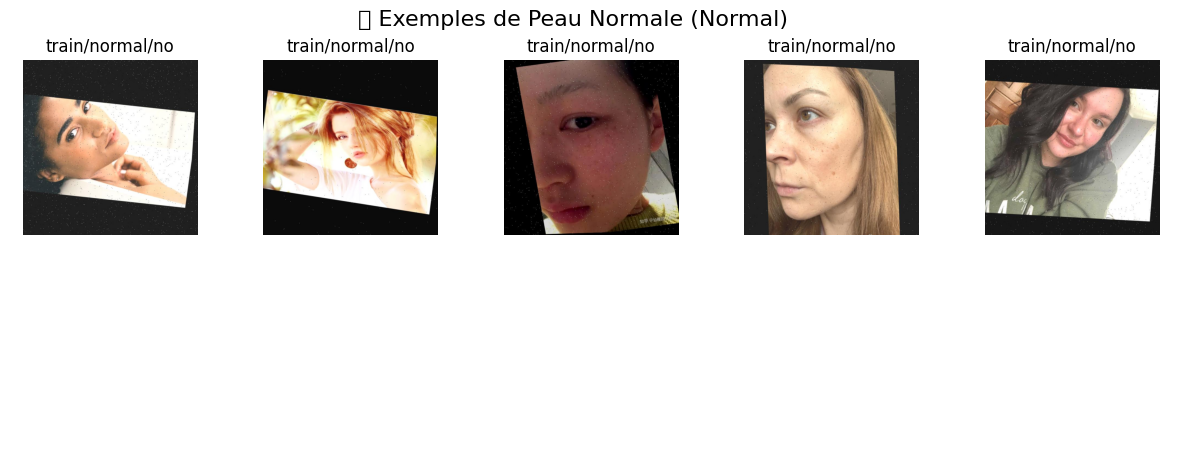

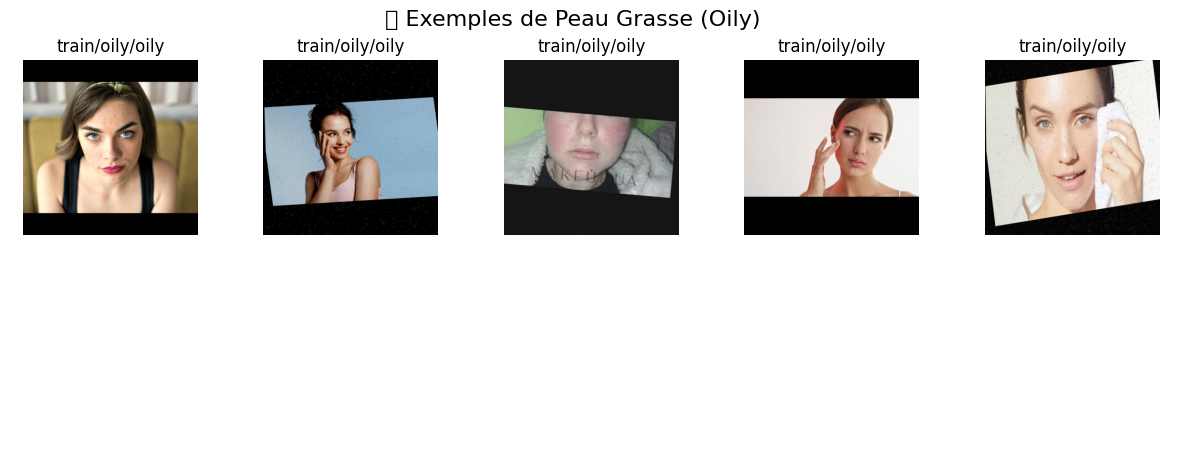

In [124]:
# 📌 Affichage des images sélectionnées
show_images(dry_images, "📸 Exemples de Peau Sèche (Dry)", dataset_root)
show_images(normal_images, "📸 Exemples de Peau Normale (Normal)", dataset_root)
show_images(oily_images, "📸 Exemples de Peau Grasse (Oily)", dataset_root)

In [125]:
# Normalisation et Conversion des Labels

# 📌 Définition des paramètres globaux
img_size = (224, 224)  # Taille des images (entrée du modèle)
batch_size = 32  # Taille des lots

# 📌 Normalisation : les valeurs des pixels seront mises entre 0 et 1
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)  # Seulement la normalisation

In [126]:
# Création d’un générateur d’images avec augmentation (seulement pour le training)
train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_root, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = valid_test_datagen.flow_from_directory(
    os.path.join(dataset_root, "valid"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = valid_test_datagen.flow_from_directory(
    os.path.join(dataset_root, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 2756 images belonging to 3 classes.
Found 262 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


In [127]:
# Création des Générateurs de Données pour le Modèle
# 📌 Récupération des indices de classes pour mapping
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# 📌 Affichage des classes détectées
print("📂 Classes détectées :", class_labels)

# 📌 Vérification du nombre d'images par catégorie
print("📊 Nombre d'images par dataset :")
print(f"Train : {train_generator.samples}")
print(f"Validation : {valid_generator.samples}")
print(f"Test : {test_generator.samples}")

📂 Classes détectées : ['dry', 'normal', 'oily']
📊 Nombre d'images par dataset :
Train : 2756
Validation : 262
Test : 134


In [128]:
# 📌 Définition du modèle MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# 📌 Geler toutes les couches du modèle de base
base_model.trainable = False

# 📌 Décongeler les 30 dernières couches pour affiner l'apprentissage
for layer in base_model.layers[-30:]:
    layer.trainable = True

# 📌 Définir l'entrée du modèle
inputs = Input(shape=(224, 224, 3))

# 📌 Passage des inputs à MobileNetV2
x = base_model(inputs, training=False)  # Utilisation correcte des entrées

# 📌 Ajout des couches supplémentaires
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation="relu", kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

outputs = Dense(3, activation="softmax")(x)

# 📌 Création du modèle final
model = Model(inputs=inputs, outputs=outputs)  # Utilisation correcte de l'entrée

In [129]:
# 📌 Fonction F1-score custom
def f1_score_custom(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater_equal(y_pred, 0.5), tf.float32)  # Seuil de 0.5

    tp = tf.reduce_sum(tf.cast(tf.equal(y_true * y_pred, 1), tf.float32))  # True Positives
    fp = tf.reduce_sum(tf.cast(tf.equal(y_true * (1 - y_pred), 0), tf.float32))  # False Positives
    fn = tf.reduce_sum(tf.cast(tf.equal((1 - y_true) * y_pred, 0), tf.float32))  # False Negatives

    precision = tp / (tp + fp + tf.keras.backend.epsilon())  # Precision
    recall = tp / (tp + fn + tf.keras.backend.epsilon())  # Recall

    return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())  # F1-score

# 📌 Fonction Focal Loss custom
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        focal_loss = weight * cross_entropy
        return K.sum(focal_loss, axis=1)
    return loss

learning_rate = 0.0004
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss=focal_loss(alpha=0.25, gamma=2.0),
              metrics=['accuracy', AUC(), Precision(), Recall(), f1_score_custom]
              )

In [130]:
# 📌 Affichage du résumé du modèle
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,431,171 (9.27 MB)

 Trainable params: 1,699,203 (6.48 MB)

 Non-trainable params: 731,968 (2.79 MB)

In [131]:
# entrainement

# 📌 Définition des paramètres d'entraînement
batch_size = 32
num_epochs = 50
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)

# 📌 Vérification des générateurs de données
print(f"📊 Nombre d'images de train : {train_generator.samples}")
print(f"📊 Nombre d'images de validation : {valid_generator.samples}")

📊 Nombre d'images de train : 2756
📊 Nombre d'images de validation : 262


In [132]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.5,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)

In [133]:
# 📌 Entraînement du modèle
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(history.history.keys())  # Voir les vraies clés disponibles

# 📌 Vérification des clés disponibles dans l'historique d'entraînement
print("\n🔍 Clés disponibles dans history.history :", history.history.keys())

# 🔹 Trouver dynamiquement la bonne clé pour chaque métrique (évite KeyError)
history_keys = history.history.keys()

train_auc_key = next((key for key in history_keys if key.startswith('auc') and not key.startswith('val')), None)
val_auc_key = next((key for key in history_keys if key.startswith('val_auc')), None)

train_precision_key = next((key for key in history_keys if key.startswith('precision') and not key.startswith('val')), None)
val_precision_key = next((key for key in history_keys if key.startswith('val_precision')), None)

train_recall_key = next((key for key in history_keys if key.startswith('recall') and not key.startswith('val')), None)
val_recall_key = next((key for key in history_keys if key.startswith('val_recall')), None)

train_f1_key = next((key for key in history_keys if key.startswith('f1_score') and not key.startswith('val')), None)
val_f1_key = next((key for key in history_keys if key.startswith('val_f1_score')), None)

# 🔹 Récupération sécurisée des métriques
final_train_acc = history.history.get('accuracy', [None])[-1]
final_val_acc = history.history.get('val_accuracy', [None])[-1]

final_train_auc = history.history.get(train_auc_key, [None])[-1] if train_auc_key else None
final_val_auc = history.history.get(val_auc_key, [None])[-1] if val_auc_key else None

final_train_precision = history.history.get(train_precision_key, [None])[-1] if train_precision_key else None
final_val_precision = history.history.get(val_precision_key, [None])[-1] if val_precision_key else None

final_train_recall = history.history.get(train_recall_key, [None])[-1] if train_recall_key else None
final_val_recall = history.history.get(val_recall_key, [None])[-1] if val_recall_key else None

final_train_f1 = history.history.get(train_f1_key, [None])[-1] if train_f1_key else None
final_val_f1 = history.history.get(val_f1_key, [None])[-1] if val_f1_key else None

# 📊 Affichage des métriques finales
print("\n📊 **MÉTRIQUES FINALES**")
print(f"✅ Accuracy - Train: {final_train_acc:.4f} | Validation: {final_val_acc:.4f}")
print(f"✅ AUC - Train: {final_train_auc:.4f} | Validation: {final_val_auc:.4f}")
print(f"✅ Precision - Train: {final_train_precision:.4f} | Validation: {final_val_precision:.4f}")
print(f"✅ Recall - Train: {final_train_recall:.4f} | Validation: {final_val_recall:.4f}")
print(f"✅ F1-score - Train: {final_train_f1:.4f} | Validation: {final_val_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 76s 656ms/step - accuracy: 0.3529 - auc_6: 0.5286 - f1_score_custom: 0.1099 - loss: 6.2002 - precision_6: 0.3515 - recall_6: 0.2971 - val_accuracy: 0.4275 - val_auc_6: 0.5840 - val_f1_score_custom: 0.1388 - val_loss: 4.8339 - val_precision_6: 0.4250 - val_recall_6: 0.3893 - learning_rate: 4.0000e-04
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 482ms/step - accuracy: 0.3737 - auc_6: 0.5449 - f1_score_custom: 0.1127 - loss: 4.3812 - precision_6: 0.3857 - recall_6: 0.3101 - val_accuracy: 0.3397 - val_auc_6: 0.5274 - val_f1_score_custom: 0.0710 - val_loss: 3.2309 - val_precision_6: 0.3710 - val_recall_6: 0.1756 - learning_rate: 4.0000e-04
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 475ms/step - accuracy: 0.3808 - auc_6: 0.5558 - f1_score_custom: 0.1032 - loss: 3.0135 - precision_6: 0.3880 - recall_6: 0.2873 - val_accuracy: 0.3931 - val_auc_6: 0.5674 - val_f1_score_custom: 0.0543 - val_loss: 2.1961 - val_precision_6: 0.4516 - val_recall_6: 0.1603 - learning_

In [134]:
import matplotlib.pyplot as plt

# 📌 Récupération des métriques
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']
train_f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

# 📌 Affichage des courbes d'apprentissage
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Courbe de perte
ax[0].plot(train_loss, label="Train Loss")
ax[0].plot(val_loss, label="Validation Loss")
ax[0].set_title("Évolution de la Perte")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Courbe de AUC
ax[1].plot(train_auc, label="Train AUC")
ax[1].plot(val_auc, label="Validation AUC")
ax[1].set_title("Évolution de l'AUC")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("AUC")
ax[1].legend()

# Courbe de F1-score
ax[2].plot(train_f1, label="Train F1-score")
ax[2].plot(val_f1, label="Validation F1-score")
ax[2].set_title("Évolution du F1-score")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("F1-score")
ax[2].legend()

plt.show()

KeyError: 'auc'